# Hindi data processing

In [1]:
import matplotlib
import tensorflow as tf 
import os,sys,glob
import pandas as pd 
sys.path.append("../")
import evaluate, src.graph
os.chdir("../")

### Creating a parsed csv file 

In [2]:
import codecs,re,unicodedata, src
data_dir = "../data/indic-TTS/hindi/hindi-female"
params = src.utils.Params('runs/hindi-text2melM4/params.json')
print(os.listdir(data_dir))
transcripts = codecs.open(os.path.join(data_dir,'txt.done.data'),'r','utf-8').readlines()

['val.csv', 'wavs', 'params.json', 'txt.done.data', 'metadata.csv', 'train.csv', 'hindi_chars.txt']


In [3]:
print(transcripts[:5])

['( text_01001 " प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का यह शोध आलेख, उस रामानंद की खोज करता है " ) \n', '( text_01002 " किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण रामानंद के, एक जुलाहे कबीर का गुरु होने से, बल्कि दोनों के समकालीन होने से भी, इनकार करता है " ) \n', '( text_01003 " उस पर, इन चार कवियों का गहरा असर है " )\n', '( text_01004 " इसे कई बार मंचित भी किया गया है " ) \n', '( text_01005 " यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रोवर के अंग्रेज़ी के मार्फ़त किए गए अनुवाद के, कुछ अंश " )\n']


In [4]:
# parsing out filenames and sentences 
transcripts_parsed = []
for line in transcripts:
    line = unicodedata.normalize('NFKD',line)
    m = re.match("\(\s+(text_[0-9]+)\s+\"(.*)\"\s+\)",line.strip())
    fname,sentence = m.groups()
    sentence = sentence.strip()
    transcripts_parsed.append([fname,sentence])

In [6]:
# there seem to be some mistaken ':' for 'ः'  
# also note that there don't seem to be numerical numbers, they've been spelled out
count = 0
for i,(_,sentence) in enumerate(transcripts_parsed):
    if ":" in sentence: 
        print(sentence)
        transcripts_parsed[i][1] = sentence.replace(':','\u0903')
# writing out to csv file 
with open(os.path.join(data_dir,'metadata.csv'),'w') as f:
    for fname,sentence in transcripts_parsed:
        if len(sentence) <= 250: # arbitrary cutoff on length (see histograms below)
            f.write("{}|{}\n".format(fname,sentence))

करीब छ: माह पूर्व, पिछली गर्मियों में ही, लाजवन्ती ने अपना तन्दूर, इस कॉलोनी में, जमाया था
पांच छ: वर्ष का बालक, जो नीली धारीदार शर्ट, और सफ़ेद हॉफ़ पैण्ट पहना है, अपने पिता का नाम, तिलक गोस्वामी बताता है, इन्क्वायरी दफ़्तर में है
व्यक्ति, जब विषयों का चिंतन करता है, विषयों के प्रति आसक्ति पैदा होती है, तब ध्यायतो, विषयान् पुंस:, और यही आसक्ति, समस्त कामनाओं की जड़ है, और अतृप्त कामनाएं, विकारों को जन्म देती हैं, इनसे ही तो हटना है
सभी इन्सान ईश्वर या खुदा की ही संतान है, अत: किसी पर अत्याचार मत करो.


### Building Character Vocabulary

In [7]:
# build hindi character vocabulary
character_set = set()
for _,sentence in transcripts_parsed:
    for char in sentence:
        character_set.add(char)

In [8]:
vocabList = sorted([c for c in character_set])
print(vocabList)
vocabString = "".join(vocabList)
with open(os.path.join(data_dir,'hindi_chars.txt'),'w') as f:
    f.write(vocabString)

[' ', ',', '.', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्']


# Data Preprocessing

### Distribution of lengths in dataset

In [9]:
import librosa
import numpy as np
import IPython.display as ipd
from src.utils import Params
from src.dsp_utils import spectrogram2wav
from scipy.io.wavfile import write 
# dsp_utils.get_spectrograms(fpath,params)

In [10]:
fnames, text_lengths, texts = src.data_load.process_csv_file(
    os.path.join(data_dir,'metadata.csv'),params,'IndicTTSHindi'
)

Processing csv file with mode: IndicTTSHindi


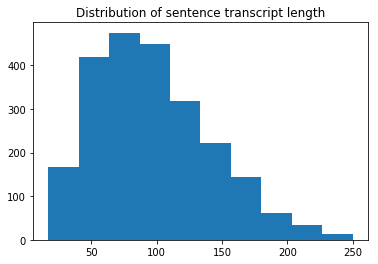

In [11]:
plt.hist(text_lengths)
plt.title('Distribution of sentence transcript length')
plt.show()

In [12]:
# get lengths of audio files 
spec_lengths = []
for i,fname in enumerate(fnames):
    print("\r{}".format(i),end='')
    y, sr = librosa.load(fname,params.sampling_rate)
    y, _ = librosa.effects.trim(y)
    mag_length = int(y.shape[0]/params.hop_length)+1
    mel_length = int(mag_length//4) 
    spec_lengths.append([mel_length,mag_length])

2303

In [17]:
print(len([ mel for mel,_ in spec_lengths if mel > 350])) # number of rejected data samples 
metadata_dt = pd.read_csv(os.path.join(data_dir,'metadata.csv'),sep='|',header=None)
metadata_dt['2'] = text_lengths
metadata_dt['3'] = [mel for mel,mag in spec_lengths]
metadata_dt.to_csv('../data/indic-TTS/hindi/hindi-female/metadata.csv',sep='|',index=False,header=None)

44


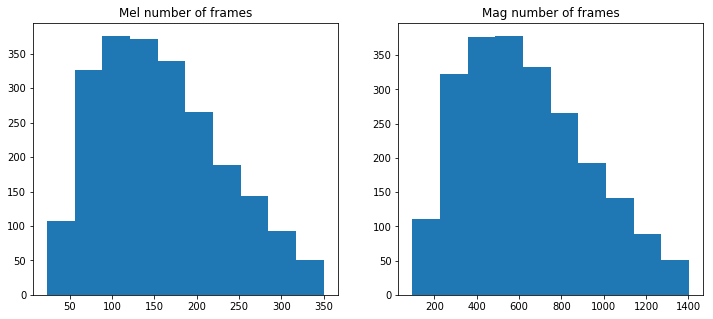

In [20]:
f = plt.figure(figsize=(12,5))
ax1 = f.add_subplot(121)
ax1.hist([mel for mel,_ in spec_lengths if mel <= 350])
plt.title('Mel number of frames')
ax2 = f.add_subplot(122)
ax2.hist([mag for mel,mag in spec_lengths if mel <= 350])
plt.title('Mag number of frames')
plt.show()

In [82]:
y, sr = librosa.load(fnames[5],sr=params.sampling_rate)
print(y.shape)
y_22k = librosa.resample(y,sr,params.sampling_rate)
ipd.Audio(y,rate=48000)

(197150,)


In [31]:
mel, mag = src.dsp_utils.get_spectrograms(fname,params,'text2mel')
mel.shape

(353, 80)

In [26]:
librosa.stft(y=y,n_fft=1024,hop_length=256,window='hann').shape

(513, 387)

### Testing audio input and output

In [ ]:
params = Params('./runs/default/params.json')
fpath = '../data/lj-speech/LJSpeech-1.0/wavs/LJ001-0006.wav/'
y, sr = librosa.load(fpath,sr=params.sampling_rate)
y, _ = librosa.effects.trim(y)

In [ ]:
y1 = np.append(y[0], y[1:] - 0.97 * y[:-1])

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(y)
plt.show()

In [ ]:
mag = np.abs(librosa.stft(y,params.n_fft,params.hop_length))
np.max(mag)

In [ ]:
mel, mag = dsp_utils.get_spectrograms(fpath,params)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(mel.T,cmap='gray',aspect=1)
plt.show()
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(mag.T,cmap='gray',aspect=0.2)
plt.show()

In [ ]:
wav = dsp_utils.spectrogram2wav(mag,params)
dsp_utils.save_wav(wav,'./dsp_tests/out_test.wav',params.sampling_rate)

In [ ]:
mag_denorm = dsp_utils._denormalize(mag,params)

## Train / Dev data split

In [1]:
import os,sys
import glob
import pandas as pd
import collections

In [8]:
csv_path = '../data/indic-TTS/hindi/hindi-female/metadata.csv'
transcripts_all = pd.read_csv(csv_path,sep='|',header=None)
transcripts_all.head()

,0,1
0,text_01001,"प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का य..."
1,text_01002,"किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण र..."
2,text_01003,"उस पर, इन चार कवियों का गहरा असर है"
3,text_01004,इसे कई बार मंचित भी किया गया है
4,text_01005,"यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रो..."


In [9]:
dev_fraction = 0.15
rand_state = np.random.RandomState(4)
transcripts_val = transcripts_all.sample(frac=dev_fraction,random_state=rand_state)
transcripts_train = transcripts_all[~(transcripts_all[0].isin(transcripts_val[0]))]
print(transcripts_val.shape)
print(transcripts_train.shape)

(348, 2)
(1970, 2)


In [10]:
# write out to separate files 
transcripts_val.to_csv('../data/indic-TTS/hindi/hindi-female/val.csv',sep='|',index=False,header=None)
transcripts_train.to_csv('../data/indic-TTS/hindi/hindi-female/train.csv',sep='|',index=False,header=None)

## Organizing gspeech dataset

In [ ]:
# get list of filenames, split by folder 
file_paths = glob.glob("../data/google-speech-commands/*/*.wav")
label_dict = collections.defaultdict(list)
for path in file_paths:
    fname = os.path.split(path)[1]
    label = os.path.split(os.path.dirname(path))[1]
    label_dict[label].append(fname)

In [ ]:
label_DF = pd.DataFrame.from_dict(label_dict,orient='index')
label_DF = label_DF.T.melt(var_name='label',value_name='fname').dropna()
label_DF = label_DF.set_index('label').drop('_background_noise_')

In [ ]:
label_DF.groupby('label').agg('count').plot(kind='bar')
plt.show()

In [ ]:
sampled_DF = label_DF.sample(5000).reset_index()
sampled_DF.groupby('label').agg('count').plot(kind='bar')
plt.show()

In [ ]:
sampled_DF.fname = sampled_DF.fname.apply(lambda x: x.split('.')[0])
sampled_DF = sampled_DF[['fname','label']]
sampled_DF['label_norm'] = sampled_DF['label']

In [ ]:
# create subset of data
dirname = '../data/gspeech-sample/'
sourcedir = '../data/google-speech-commands/'
destdir = os.path.join(dirname,'wavs') 

# copy files over
os.mkdir(destdir)
for index,row in sampled_DF.iterrows():
    print(index),
    fname,label = row['fname']+'.wav',row['label']
    os.system("cp {} {}".format(os.path.join(sourcedir,label,fname),
                                os.path.join(destdir,fname)))
    sys.stdout.flush()
# write out label csv file
sampled_DF.to_csv(os.path.join(dirname,'metadata.csv'),index=False,header=False,sep='|')